**Based on the data and your ideas, plan strategies to double the total restaurant visitors
in six months.**

- packages

In [1]:
# data
# ==============================================================================
import numpy as np
import pandas as pd
import yaml, requests, re, string, random, psycopg2

# plot pretty figures
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

- functions

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

- all the data was uploaded into a database an the next lines are to get the info

In [ ]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

In [4]:
q = """
    select 
            *
    from
            kaggle_data.didi.restaurants_visitors;      
"""

In [5]:
df_raw = pd.read_sql(sql = q, con = db_conn_post)

C:\Users\migue\AppData\Local\Temp/ipykernel_13172/2654062988.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(sql = q, con = db_conn_post)


In [6]:
df_raw['day_of_week'] = df_raw['visit_date'].dt.day_name()

In [7]:
df_raw.head(1)

,id,visit_date,visit_datetime,reserve_datetime,reserve_visitors,day_of_week
0,db80363d35f10926,2016-01-01,2016-01-01,2016-01-01 01:00:00,5,Friday


In [8]:
df = df_raw.copy()

In [9]:
df.set_index('visit_date', inplace = True)

In [10]:
df = df.resample('D').sum()

C:\Users\migue\AppData\Local\Temp/ipykernel_13172/1404007749.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample('D').sum()


*The chart clearly illustrates a significant increase in visitor numbers towards the end of the year and during March. It is important to note, however, that this sudden surge in visitor growth during the year-end period may appear unusual and warrants further investigation.*

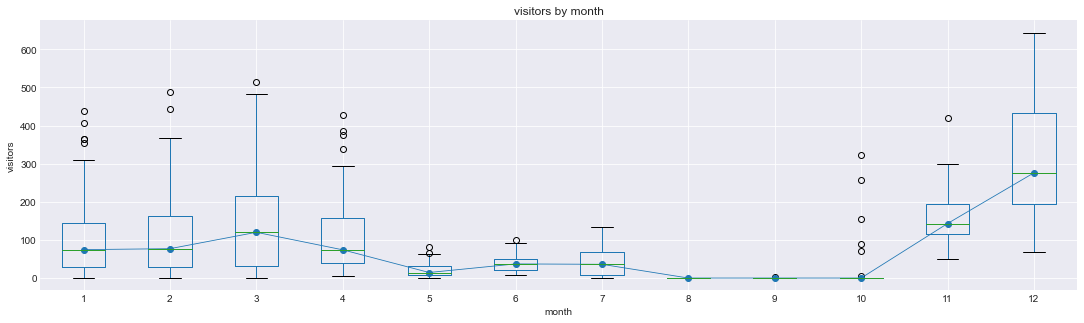

In [11]:
fig, ax = plt.subplots(figsize=(18, 5))
df['month'] = df.index.month
df.boxplot(column='reserve_visitors', by='month', ax=ax,)
df.groupby('month')['reserve_visitors'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('visitors')
ax.set_title('visitors by month')
fig.suptitle('');

*The days that hold the greatest significance are the 5th and 6th, as they conveniently align with the weekend. Implementing a promotional campaign during these days could effectively boost visitor numbers and further enhance the overall turnout.*

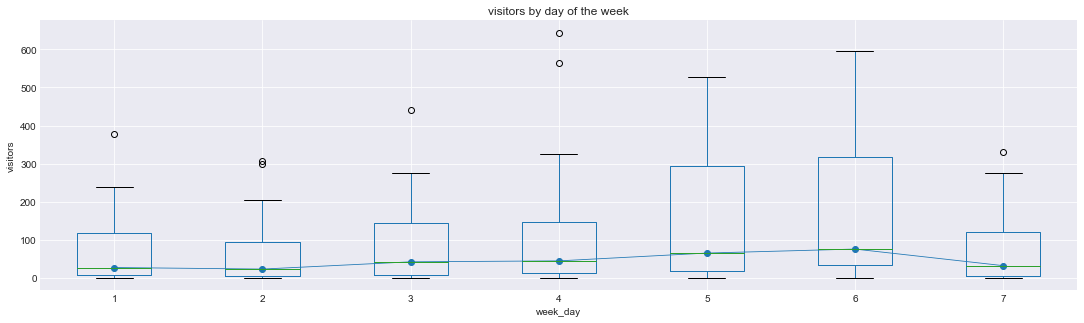

In [12]:
fig, ax = plt.subplots(figsize=(18, 5))
df['week_day'] = df.index.day_of_week + 1
df.boxplot(column='reserve_visitors', by='week_day', ax=ax)
df.groupby('week_day')['reserve_visitors'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('visitors')
ax.set_title('visitors by day of the week')
fig.suptitle('');

In [13]:
q = """
    select 
            *
    from
            kaggle_data.didi.date_info;      
"""

In [14]:
df_date_info = pd.read_sql(sql = q, con = db_conn_post)

C:\Users\migue\AppData\Local\Temp/ipykernel_13172/324960418.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_date_info = pd.read_sql(sql = q, con = db_conn_post)


In [15]:
df_raw.head(1)

,id,visit_date,visit_datetime,reserve_datetime,reserve_visitors,day_of_week
0,db80363d35f10926,2016-01-01,2016-01-01,2016-01-01 01:00:00,5,Friday


In [16]:
df_date_info.head(1)

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1


In [17]:
df_h = df_raw.merge(df_date_info, left_on = 'visit_date', right_on = 'calendar_date')

In [18]:
df_h.head(1)

,id,visit_date,visit_datetime,reserve_datetime,reserve_visitors,day_of_week_x,calendar_date,day_of_week_y,holiday_flg
0,db80363d35f10926,2016-01-01,2016-01-01,2016-01-01 01:00:00,5,Friday,2016-01-01,Friday,1


In [19]:
df_h.drop(columns = ['day_of_week_y', 'calendar_date'], inplace = True)

In [20]:
df_h.rename(columns = {'day_of_week_y':'day_of_week'}, inplace = True)

In [21]:
df_h.head(1)

,id,visit_date,visit_datetime,reserve_datetime,reserve_visitors,day_of_week_x,holiday_flg
0,db80363d35f10926,2016-01-01,2016-01-01,2016-01-01 01:00:00,5,Friday,1


In [22]:
df_h = df_h[['visit_date','reserve_visitors', 'holiday_flg']].groupby(by = ['visit_date', 'holiday_flg'], as_index = False).sum()

In [23]:
df_h.drop(columns = ['visit_date'], inplace = True)

In [24]:
df_h['holiday_flg'] = df_h['holiday_flg'].astype('str')

*The surge in visitors to restaurants during holidays is not a coincidence. However, to confirm this trend, a thorough analysis is required. By aligning marketing campaigns with holidays, we can strategically increase the number of visits to restaurants and capitalize on this pattern.*

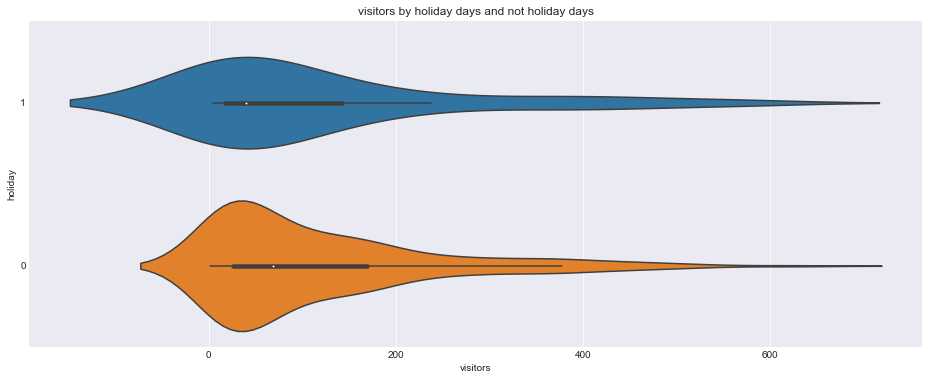

In [25]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.violinplot(
    x       = 'reserve_visitors',
    y       = 'holiday_flg',
    data    = df_h,
    palette = 'tab10',
    ax      = ax
)
ax.set_title('visitors by holiday days and not holiday days')
ax.set_xlabel('visitors')
ax.set_ylabel('holiday');

In [26]:
df_h = df_h.groupby(by = ['holiday_flg'], as_index = False).sum()

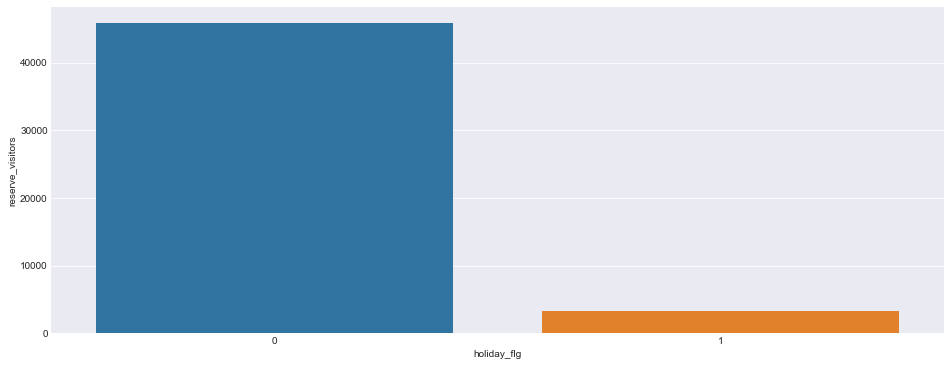

In [27]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x = 'holiday_flg', y = 'reserve_visitors', data = df_h)
plt.show()

In [33]:
del df
df = df_raw.copy()
df['visit_hour'] = df_raw['visit_datetime'].dt.hour

In [37]:
df_hour = df[['reserve_visitors', 'visit_hour']].groupby(by = 'visit_hour', as_index = False).sum()

*Based on the information provided by the chart, it is evident that there are specific hours during which the number of visitors is significantly higher. This suggests that visitors have a preference for dinners at the establishment. Capitalizing on this insight, a promotional offer targeted at friends and dinners could be highly effective in attracting more customers during those peak hours.*

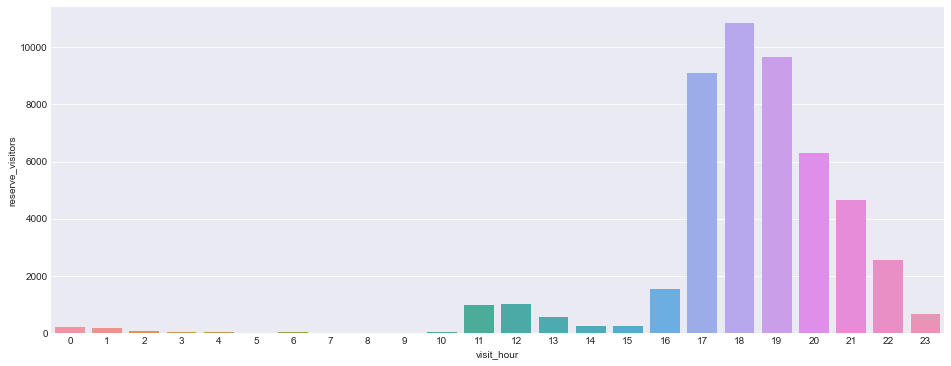

In [38]:
fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(x = 'visit_hour', y = 'reserve_visitors', data = df_hour)
plt.show()

 **`conclusions`**<br><br>
*In conclusion, based on the analysis of the data, we can observe that the end of the year and holidays result in increased visitors to restaurants. Additionally, weekends tend to be favorable for attracting more customers. Therefore, aligning marketing campaign strategies with these peak periods can be an effective way to further increase visitors to restaurants. By leveraging the holiday season and targeting weekends, restaurants can capitalize on the higher demand and attract more customers. Implementing targeted promotional offers, special menus, or themed events during these periods can be particularly effective in driving customer engagement and boosting restaurant visits. Overall, strategic alignment of campaign strategies with holiday seasons and weekends can have a positive impact on increasing visitors and enhancing the success of restaurants.*

<br>

*In terms of consumption patterns, there are two key factors to consider. Firstly, analyzing the peak hours when visitors frequent the restaurants provides valuable insights. Based on this data, we can strategically design promotions targeting dinner or group outings, which are the preferred times for customers. By tailoring our marketing efforts to these specific timeframes, we can effectively attract more customers during these periods.*

*Secondly, implementing dynamic pricing strategies can be highly advantageous. Dynamic pricing allows us to adjust prices in real-time based on various factors such as demand, time of day, or special events. This approach enables us to attract price-conscious customers by offering competitive rates during slower periods while maximizing revenue during peak times. Furthermore, dynamic pricing allows for personalized pricing options, which can be tailored to individual customer preferences. By offering personalized prices, we can attract new clients who appreciate customized experiences and, in turn, enhance customer loyalty.*

*In summary, by leveraging insights on consumption hours and implementing dynamic pricing strategies, we can optimize revenue generation and attract a broader customer base. Aligning promotional activities with peak hours and providing personalized pricing options will contribute to increasing customer loyalty and driving business growth.*

**Imagine that these restaurants are in your city (and not in Japan), what other data would you want to join in order of get more insights to increase the visitors**

*In addition to analyzing consumption patterns and implementing effective marketing strategies, it is crucial to consider key economic factors that can impact the restaurant industry. These factors include:*

*Confidence Index: The confidence index reflects the level of confidence that consumers have in the economy. A higher confidence index typically indicates a positive outlook, which can lead to increased consumption. Monitoring the confidence index enables us to gauge consumer sentiment and make informed decisions regarding pricing, promotions, and expansion plans.*

*Inflation: Inflation can significantly influence consumer behavior and purchasing power. As inflation rises, the cost of goods and services increases, which may result in reduced consumption of certain items. It is important to closely monitor inflation trends and adjust pricing strategies accordingly to maintain competitiveness while considering the potential impact on customer spending habits.*

*Interest Rates: Interest rates play a critical role in consumer borrowing and spending. Higher interest rates can lead to increased borrowing costs, particularly in credit card transactions. This can impact consumer discretionary spending, including visits to restaurants. Understanding the relationship between interest rates and consumer behavior allows us to anticipate potential fluctuations in customer demand and adjust our business strategies accordingly.*

*In addition to analyzing consumption patterns and considering economic factors, it is essential to incorporate insights from reputable consulting firms such as Nielsen and Kantar. These firms provide valuable data and market research that can further enhance our understanding of the restaurant industry landscape.*

*For instance, according to Kantar's research on consumer behavior in Mexico, it reveals some insightful findings. It highlights that only 25% of consumers are likely to visit cafeterias, indicating a decrease of 20% compared to previous years. Similarly, the research shows that 28% of consumers are inclined to dine out at restaurants, representing a 28% decrease.*

<img src="kantar.png" alt="kantar" width="900" height="700">

*Another thing to consider is the weather can indeed have a significant impact on restaurant visits. Factors such as heavy rain or extreme temperatures can influence people's dining preferences and behaviors. Here are some additional considerations related to weather and its impact on restaurant visits:*

*Delivery and Takeout: Inclement weather, such as heavy rain, may discourage people from going out to eat. Instead, they might prefer to order food through delivery applications or opt for takeout options. Restaurants can take advantage of this trend by promoting their delivery services or offering special discounts for online orders.*

*Seasonal Menus: Weather conditions can influence people's cravings and preferences for certain types of food. For example, during colder or rainy seasons, customers may be more inclined to choose warm and comforting dishes like soups, stews, or hot beverages. Restaurants can adjust their menus accordingly and feature seasonal items that cater to these preferences.*

*Indoor vs. Outdoor Seating: Extreme weather conditions, such as heavy rain or extremely hot temperatures, can impact the demand for outdoor seating areas. Restaurants with outdoor spaces may experience lower customer turnout during unfavorable weather conditions, while indoor seating areas may become more popular. Flexibility in providing comfortable seating options, such as heaters or shade, can help attract customers regardless of the weather.*

*Promotions and Specials: Restaurants can leverage weather conditions as part of their marketing strategies. For example, offering promotions on rainy days or during low temperatures, such as discounted prices on warm soups or beverages, can entice customers to visit or order from the restaurant. Weather-specific promotions can help drive traffic during slower periods.*

*In `conclusion`, to further enhance our analysis and decision-making process, it is important to consider various factors that influence the business environment. This includes taking into account the prevailing economic conditions, insights from the market, and even weather conditions.*

*Examining the economic environment allows us to gauge the overall health of the economy and identify any potential impacts on consumer spending patterns. Factors such as the confidence index, inflation rates, and interest rates can provide valuable insights into consumer behavior and help us anticipate any shifts in consumption trends.*

*Additionally, incorporating insights from the market, including data and research from reputable firms, allows us to understand the broader industry landscape. This information can provide valuable insights into consumer preferences, market trends, and competitive dynamics, enabling us to make informed decisions and develop effective strategies.*

*Lastly, considering weather conditions is crucial, especially for businesses in the hospitality industry. Weather can significantly influence consumer behavior, particularly when it comes to dining out or visiting recreational establishments. By understanding how weather patterns affect consumer preferences and behavior, we can tailor our marketing efforts and operational strategies accordingly.*

*By integrating these elements into our business analysis, we gain a more comprehensive and holistic view of the factors impacting our industry. This knowledge empowers us to make well-informed decisions, adapt our strategies to changing market conditions, and ultimately drive business success in a dynamic and competitive environment.*

**How many channels can you think of downloading a DiDi Rides APP and how will you 
estimate the quality and cost of each channel?**

- Channels to download DiDi Ripes App
  - Official app stores like Apple app store or Google Play
  - Oficial website
  - Social media platforms like Facebook, Instagram, Discord, etc.
  - Parthner websites
<br>
- Quality, to measure the quality the next are some KPIs
  - Downloads
  - Installs
  - User ratings and reviews
  - Retention rate
  - Active users
  - Crashes and bugs
  - App store ranking
<br>
- Cost, to measure the cost the next are some KPIs
  - Marketings cost
  - User acquisition cost
  - Customer lifetime
  - Cost per user (revenue per user)
  - Cost efficiency

**We want to build up a model to predict “Possible Churn Users” for DiDi Rides APP (e.g.: 
no trips in the past 4 weeks). Please list all features that you can think about and the 
data mining or machine learning model or other methods you may use for this case.**

The following features have the potential to aid in predicting churn:
- trips over the last 4 weeks
- average ticket over the last 8 weeks
- user feedback
- usage frequency
- promotional interactions
- time on the app
- price from the market
- quality of service
- criminal index 
- bad news related with the app